In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

In [2]:
# Cargar el dataset

filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/solar_wind.csv"
dF = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")

df_A = dF.loc[dF['period']=='train_a']
df_A = df_A.dropna()

In [3]:
# Calcular el número de valores a reemplazar
#features = ['bx_gse', 'by_gse', 'bz_gse', 'theta_gse', 'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt', 'density', 'speed', 'temperature']
features = ['bt']
anomaly_factor = 0.17
# Crear una copia del DataFrame para no modificar el original
df_new = df_A.copy()

for a in features:
  num_replace = int(df_A[a].size * anomaly_factor)

  # Obtener una muestra aleatoria de índices de fila para reemplazar
  replace_idx = np.random.choice(df_A.index, size=num_replace, replace=False)

  # Reemplazar los valores seleccionados con valores aleatorios entre -90 y 1050
  #new_values = np.random.uniform(-90, 1050, size=num_replace)
  new_values = np.random.uniform(0, 75, size=num_replace)
  df_new.loc[replace_idx, a] = new_values

  # Crear la columna "class" con los valores correspondientes
  df_new.loc[df_A[a] != df_new[a], 'class'] = 1
  df_new.loc[df_A[a] == df_new[a], 'class'] = 0

In [4]:
print('En el todo el dataset:')
count = (df_new['class'] == 1).sum()
count2 = (df_new['class'] != 1).sum()
print(f'El número de anomalias es {count} de {count2} valores normales')
cociente = count / count2
print(f'La relacion de anomalias es {cociente}')

En el todo el dataset:
El número de anomalias es 237074 de 1157481 valores normales
La relacion de anomalias es 0.20481891279424888


In [5]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_data = df_new.sample(frac=0.8, random_state=0)
test_data = df_new.drop(train_data.index)

In [6]:
train_df = pd.DataFrame(train_data, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
print('En el train set:')
count = (train_df['class'] == 1).sum()
count2 = (train_df['class'] != 1).sum()
print(f'El número de anomalias es {count} de {count2} valores normales')
cociente = count / count2
print(f'La relacion de anomalias es {cociente}')

En el train set:
El número de anomalias es 189740 de 925904 valores normales
La relacion de anomalias es 0.2049240526015656


In [7]:
test_df = pd.DataFrame(test_data, columns = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','class'])
print('En el test:')
count = (test_df['class'] == 1).sum()
count2 = (test_df['class'] != 1).sum()
print(f'El número de anomalias es {count} de {count2} valores normales')
cociente = count / count2
print(f'La relacion de anomalias es {cociente}')

En el test:
El número de anomalias es 47334 de 231577 valores normales
La relacion de anomalias es 0.2043985369876974


In [8]:
# Preparo el dataset en X e y y elimino columnas no necesarias
y = test_data['class']
y_full = test_data
train_data = train_data.drop(["timedelta", "period", "source", 'class'], axis=1)
test_data = test_data.drop(["timedelta", "period", "source", 'class'], axis=1)

In [9]:
# Normalizar los datos utilizando StandardScaler()
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [10]:
# Crear un modelo de SVM utilizando scikit-learn
model = OneClassSVM(kernel='rbf', nu=0.01)

In [11]:
# Entrenar el modelo utilizando los datos de entrenamiento
model.fit(train_data)

OneClassSVM(nu=0.01)

In [12]:
# Utilizar el modelo para hacer predicciones en los datos de prueba
predictions = model.predict(test_data)

In [13]:
# Comparar las predicciones con los valores reales de "class" y generar una matriz de confusión para evaluar el modelo
predictions[predictions == 1] = 0
predictions[predictions == -1] = 1

In [14]:
y_full = y_full.to_numpy()

In [15]:
confusion_matrix = pd.crosstab(y_full[:, -1], predictions, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)

Predicted       0     1
Actual                 
0.0        229562  2015
1.0         46415   919


In [16]:
pd_predictions = pd.DataFrame(predictions)
column_10 = predictions#[:, 10]
is_one = column_10 ==1
# Asignar 1 a los elementos que sean True y 0 a los elementos que sean False
has_ones = np.where(is_one, 1, 0)

In [20]:
pd_predictions = pd.DataFrame(predictions, columns=['class'])
#has_ones_pd = pd.DataFrame(has_ones, columns=['class'])
count = (pd_predictions['class'] == 1).sum()
count1 = (pd_predictions['class'] == 0).sum()
print(f'El número de anomalias predecidas es {count} y {count1} valores normales')

El número de anomalias predecidas es 2934 y 275977 valores normales


In [21]:
from sklearn.metrics import classification_report
 
print(classification_report(pd_predictions, y))
#print(classification_report(predictions_class[:,1], y))

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    275977
           1       0.02      0.31      0.04      2934

    accuracy                           0.83    278911
   macro avg       0.51      0.57      0.47    278911
weighted avg       0.98      0.83      0.90    278911



In [22]:
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix
class visualization:
  labels = ["Normal","Anomal"]
  def draw_confusion_matrix(self, y, ypred):
    matrix = confusion_matrix(y, ypred)

    plt.figure(figsize=(10,8))
    colors=["orange", "green"]
    sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("Realidad")
    plt.xlabel("Predicción")
    plt.show()

In [23]:
y_pd = pd.DataFrame(y, columns = ['class'])
count = (y_pd['class'] == 1).sum()
print(f'El número de anomalias reales es {count}')

El número de anomalias reales es 47334


In [25]:
#predictions_class_pd  = pd.DataFrame(predictions_class, columns = ['1','class'])
count = (pd_predictions['class'] == 1).sum()
print(f'El número de anomalias predecidas es {count}')

El número de anomalias predecidas es 2934


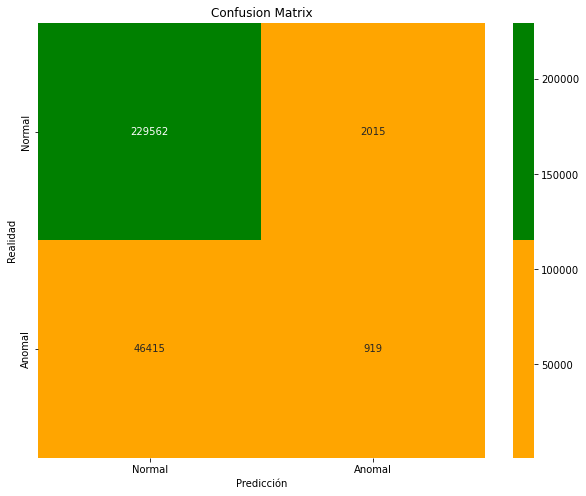

In [26]:
viz = visualization()
viz.draw_confusion_matrix(y_pd, pd_predictions)